## Large deviations of Ornstein–Uhlenbeck process

Necessary steps:
- [x] OU process
- [x] Formulate large-deviation function (likely variance is a good chance)
- [ ] Implement muca to sample large deviations

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Random
using StatsBase
using BenchmarkTools
using Plots
using MonteCarloX

  Activating project at `~/.julia/dev/MonteCarloX/examples`


### Random walk

We consider a simple random walk in 1D with Gaussian update


In [2]:
struct RWTrajectory
    xs::Vector{Float64}
    rands::Vector{Float64}
    randns::Vector{Float64}
    T::Float64
    dt::Float64
    steps::Int
    D::Float64
    noise_scale::Float64
    function RWTrajectory(rng::AbstractRNG, D::Float64, T::Float64, dt::Float64; x0::Float64=0.0)
        steps = Int(T/dt)
        noise_scale = sqrt(2 * D * dt) # dt necessary for the discrete-time implementation
        rands = rand(rng, steps)
        steps_2 = div(steps, 2)
        if steps_2*2 != steps
            steps_2 += 1
        end
        randns = [calc_randn_from_rand(rands[2i-1], rands[2i]) for i in 1:steps_2]
        randns = vcat(randns...)  # flatten the array of tuples
        RWT = new(ones(steps+1)*x0, rands, randns, T, dt, steps, D, noise_scale)
        resample!(RWT)
        return RWT
    end
end
calc_randn_from_rand(r1,r2) = sqrt(-2*log(r1)) * [cos(2*pi*r2), sin(2*pi*r2) ]

@inline function update_randn!(RWT::RWTrajectory, i::Integer) 
    # find the right index pair for the given index, which is either i+1 or i-1
    if isodd(i)
        idx1 = i
        idx2 = i + 1
    else
        idx1 = i - 1
        idx2 = i
    end
    RWT.randns[idx1:idx2] = calc_randn_from_rand(RWT.rands[idx1], RWT.rands[idx2])
end

function resample!(RWT::RWTrajectory, i0::Integer)
    _x = RWT.xs[i0]
    @inbounds @simd for i in i0:RWT.steps
        _x += RWT.noise_scale * RWT.randns[i]
        RWT.xs[i+1] = _x
    end
end
@inline resample!(RWT::RWTrajectory) = resample!(RWT, 1)

resample! (generic function with 2 methods)

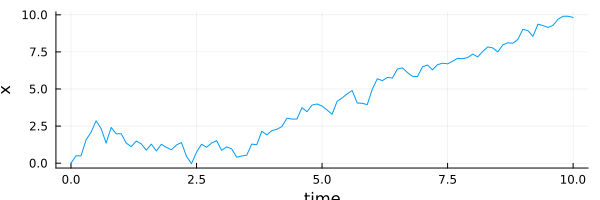

In [3]:
rng = MersenneTwister(1234)
T = 10.0
dt = 0.1
RWT = RWTrajectory(rng, 1.0, T, dt; x0=0.0)
plot(0:dt:T, RWT.xs, label=nothing, xlabel="time", ylabel="x", size=(600,200))

In [4]:
using BenchmarkTools
@btime resample!($RWT)
@code_warntype resample!(RWT)

  63.436 ns (0 allocations: 0 bytes)
MethodInstance for resample!(::RWTrajectory)
  from resample!(RWT::RWTrajectory) @ Main ~/.julia/dev/MonteCarloX/examples/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:46
Arguments
  #self#::Core.Const(Main.resample!)
  RWT::RWTrajectory
Body::Nothing
1 ─      nothing
│   %2 = Main.resample!::Core.Const(Main.resample!)
│   %3 = (%2)(RWT, 1)::Core.Const(nothing)
└──      return %3



### Large-deviation sampling

In [5]:
# do large-deviation sampling on the endpoints of the trajectory
mutable struct RWSystem
    RWT::RWTrajectory
    function RWSystem(trajectory::RWTrajectory)
        new(trajectory)
    end
end
function endpoint(sys::RWSystem)
    return sys.RWT.xs[end]
end

function rng_shift!(sys::RWSystem, alg::AbstractImportanceSampling; shift_size::Float64=0.1)
    i = rand(alg.rng, 1:sys.RWT.steps)
    tmp_xs = deepcopy(sys.RWT.xs[i:end])
    tmp_rand = sys.RWT.rands[i]
    endpoint_old = endpoint(sys)
    # shift the random number at index i
    sys.RWT.rands[i] += shift_size * (rand(alg.rng) - 0.5)
    # reject if out of bounds (TODO: this is a bit hacky, we should have a better way to handle this)
    if sys.RWT.rands[i] < 0 || sys.RWT.rands[i] >= 1
        accept!(alg, endpoint_old, endpoint_old) # still need to update the acceptance ratio
        sys.RWT.xs[i:end] .= tmp_xs
        sys.RWT.rands[i] = tmp_rand
        return nothing
    end
    update_randn!(sys.RWT, i) # update the corresponding randn value
    resample!(sys.RWT, i)
    endpoint_new = endpoint(sys)
    if accept!(alg, endpoint_new, endpoint_old) 
        # accept the new trajectory, do nothing
    else
        sys.RWT.xs[i:end] .= tmp_xs
        sys.RWT.rands[i] = tmp_rand
        update_randn!(sys.RWT, i) # not super efficient but that comes later
    end
    return nothing
end

rng_shift! (generic function with 1 method)

### Metropolis

This raises an important point: We need to ensure that the random numbers remain to be drawn from a Gaussian distribution!

In [55]:
function metropolis_run(rng, bins;β=0, D=1.0, T=10.0, dt=0.1, x0=0.0)
    print("Running Metropolis with β = ", β, " ... ")
    RWT = RWTrajectory(rng, D, T, dt; x0=x0)
    sys = RWSystem(RWT)
    alg = Metropolis(MersenneTwister(42), β=β)

    data = Measurements([
        :mean => endpoint => Float64[],
    ], interval=100)
    hist = Measurements([
        :mean => endpoint => fit(Histogram, [], bins),
    ], interval=1)


    for i in 1:10_000
        rng_shift!(sys, alg, shift_size=0.3)
        measure!(data, sys, i)
    end

    for i in 1:10_000_000
        rng_shift!(sys, alg, shift_size=0.3)
        measure!(hist, sys, i)
        measure!(data, sys, i)
    end
    println("acceptance rate = ", acceptance_rate(alg))
    return data, hist, sys
end
bins = -60:0.1:20.0
βs = [0.0, 1.5, 3.0]
results = Dict(β => metropolis_run(rng, bins, β=β) for β in βs)

Running Metropolis with β = 0.0 ... acceptance rate = 1.0
Running Metropolis with β = 1.5 ... acceptance rate = 0.8648949050949051
Running Metropolis with β = 3.0 ... acceptance rate = 0.4867320679320679


Dict{Float64, Tuple{Measurements{Symbol, IntervalSchedule}, Measurements{Symbol, IntervalSchedule}, RWSystem}} with 3 entries:
  0.0 => (Measurements{Symbol, IntervalSchedule}(Dict{Symbol, Measurement}(:mea…
  1.5 => (Measurements{Symbol, IntervalSchedule}(Dict{Symbol, Measurement}(:mea…
  3.0 => (Measurements{Symbol, IntervalSchedule}(Dict{Symbol, Measurement}(:mea…

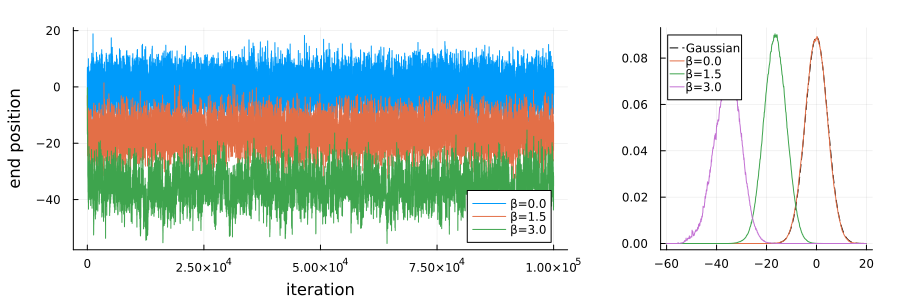

In [56]:
using Distributions

p1 = plot(label="β=0.0", xlabel="iteration", ylabel="end position")
y_gauss = pdf.(Normal(0, sqrt(2*sys.RWT.D*T)), bins)
p2 = plot(bins, y_gauss, label="Gaussian", linestyle=:dash, color=:black)
# plot all the βs from results
for β in βs
    plot!(p1, results[β][:1][:mean].data, label="β=$β")
    plot!(p2, results[β][:2][:mean].data.edges[1][1:end-1], results[β][:2][:mean].data.weights/norm, label="β=$β")
end

plot(p1, p2, layout = @layout([a{0.7w} b]), size=(900,300), margin=5Plots.mm)

β = 0.0: mean randn = 0.00714615199101078, mean rand = 0.4588405417413783
β = 1.5: mean randn = -0.32880298725738305, mean rand = 0.5093665129621555
β = 3.0: mean randn = -0.732191660681805, mean rand = 0.5156814418017693


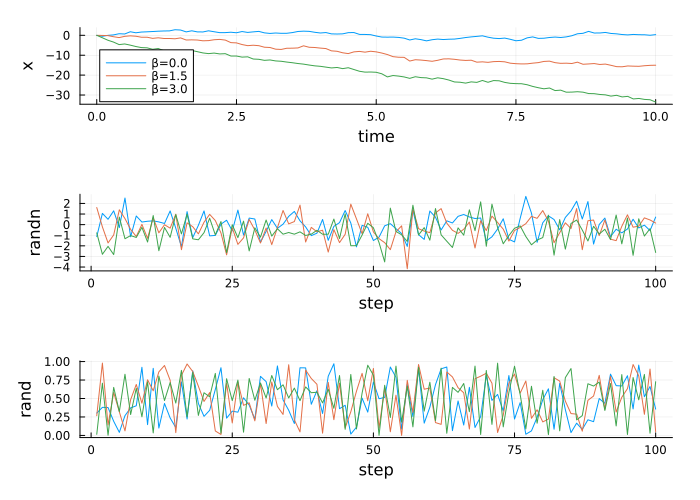

In [60]:
# plot final trajectories and random numbers in a multiplot
plt1 = plot(label=nothing, xlabel="time", ylabel="x", size=(600,300))
plt2 = plot(label=nothing, xlabel="step", ylabel="randn", size=(600,300))
plt3 = plot(label=nothing, xlabel="step", ylabel="rand", size=(600,300))

for β in βs
    sys = results[β][3]
    plot!(plt1, 0:dt:T, sys.RWT.xs, label="β=$β")
    plot!(plt2, 1:sys.RWT.steps, sys.RWT.randns[1:sys.RWT.steps], label=nothing)
    # add mean randn value as a dashed line and match the color to the trajectory
    mean_randn = mean(sys.RWT.randns[1:sys.RWT.steps])
    plot!(plt3, 1:sys.RWT.steps, sys.RWT.rands, label=nothing)
    mean_rand = mean(sys.RWT.rands)
    println("β = ", β, ": mean randn = ", mean_randn, ", mean rand = ", mean_rand)
end

plot(plt1, plt2, plt3, layout = @layout([a; b; c]), size=(700,500), margin=5Plots.mm)

### Multicanonical

In [10]:
alg = Multicanonical(MersenneTwister(1234), BinnedLogWeight(-10.0:0.1:10.0, 0.0))
@btime rng_shift!(sys, alg)

UndefVarError: UndefVarError: `sys` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [11]:
bound_left = -5.0
bound_right = 5.0
idx_bound_left = searchsortedfirst(alg.histogram.bins[1].edges, bound_left)
idx_bound_right = searchsortedlast(alg.histogram.bins[1].edges, bound_right)
print("idx_left = ", idx_bound_left, ", idx_right = ", idx_bound_right, "\n")

idx_left = 51, idx_right = 151


In [12]:
num_iter = 20
histograms = BinnedLogWeight[]
logweights = BinnedLogWeight[]
using ProgressMeter

@showprogress 1 "Running iterations..." for i in 1:num_iter    
    # thermalize the system
    for i in 1:10_000
        rng_shift!(sys, alg)
    end
    # reset and start sampling
    reset!(alg)
    for i in 1:1_000_000
        rng_shift!(sys, alg)
    end
    # update the logweight
    update_weight!(alg; mode=:simple)   
    # make sure that weights decrease to the ends so that system does not run away
    weight_bound_left = alg.logweight[idx_bound_left]
    weight_bound_right = alg.logweight[idx_bound_right]
    for i in 1:idx_bound_left
        alg.logweight[i] = weight_bound_left
    end
    for i in idx_bound_right+1:size(alg.logweight)[1]
        alg.logweight[i] = weight_bound_right
    end

    # record the histogram and weights
    push!(histograms, deepcopy(alg.histogram))
    push!(logweights, deepcopy(alg.logweight))
end

UndefVarError: UndefVarError: `sys` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [13]:
function plot_histograms_and_logweights(xlabel, hist_vec::Vector{BinnedLogWeight}, lw_vec::Vector{BinnedLogWeight}; title_prefix="")
    n = length(hist_vec)
    cols = palette(:viridis, max(n, 2))[1:n]
    xs = collect(hist_vec[1].bins[1])

    # Plot histograms
    p1 = plot(xs, hist_vec[1].weights; lw=2, color=cols[1], xlabel=xlabel, ylabel="counts", title="$(title_prefix)histograms", legend=false)
    for i in 2:n
        plot!(p1, xs, hist_vec[i].weights; lw=2, color=cols[i])
    end

    # Plot logweights
    p2 = plot(xs, -deepcopy(lw_vec[1].weights); lw=2, color=cols[1], xlabel=xlabel, ylabel="-logweight", title="$(title_prefix)weights", legend=false)
    i0 = 1
    for i in 2:n
        w = deepcopy(lw_vec[i].weights)
        i0 = findfirst(==(0), xs)
        if i0 !== nothing
            w .-= w[i0]
        end
        plot!(p2, xs, w; lw=2, color=cols[i])
    end

    plt = plot(p1, p2, layout=(1,2), size=(800,300), margin=4Plots.mm)
    return plt
end

plot_histograms_and_logweights (generic function with 1 method)

In [14]:
# call the plotting function
plot_histograms_and_logweights("mean", histograms, logweights, title_prefix="OU process - ")

BoundsError: BoundsError: attempt to access 0-element Vector{BinnedLogWeight} at index [1]

In [15]:
# print variance etc of OUT
using StatsBase
println("mean (StatsBase) = ", mean(OUT.xs))
println("mean (sys) = ", _mean(sys))
plot(0:dt:T, OUT.xs, label=nothing, xlabel="time", ylabel="x", size=(600,300))

UndefVarError: UndefVarError: `OUT` not defined in `Main`
Suggestion: check for spelling errors or missing imports.